# Kenali Sapinya
Anda memiliki 2 jenis gambar yaitu sapi tanpa background dan sapi dengan background.
Buatlah model pola sapi dengan gambar tanpa background. Kemudian gunakan pola tersebut untuk mendeteksi sapi dengan background. Gunakan interpolasi dan finite difference atau metode lain di dalam materi metode numerik.

Note:
1. Tidak boleh menggunakan library kecuali untuk membaca image
2. Algoritma Anda rancang sendiri dan implementasikan sendiri from scratch
3. Satu kelompok terdiri dari 4 orang.

In [22]:
import cv2
import matplotlib.pyplot as plt

[ WARN:0@523.297] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('./sapi_x.jpg'): can't open/read file: check file path/integrity


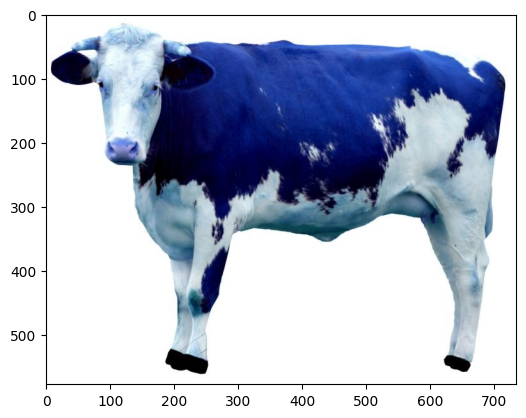

In [23]:
sapi_tanpa_bg1 = cv2.imread('./sapi1.jpg')
sapi_tanpa_bg2 = cv2.imread('./sapi2.jpeg', cv2.IMREAD_GRAYSCALE)
sapi_tanpa_bg3 = cv2.imread('./sapi3.jpg', cv2.IMREAD_GRAYSCALE)
sapi_dgn_bg = cv2.imread('./sapi_x.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(sapi_tanpa_bg1, cmap='gray')

In [24]:
image=sapi_tanpa_bg1

def get_shape(image):
    height = len(image)
    width = len(image[0])
    return height, width

def resize_image(image, new_width, new_height):
    height, width = get_shape(image)

    scale_x = width / new_width
    scale_y = height / new_height

    resized_image = [[0] * new_width for _ in range(new_height)]

    for y in range(new_height):
        for x in range(new_width):
            src_x = int(x * scale_x)
            src_y = int(y * scale_y)

            x1 = src_x
            x2 = min(x1 + 1, width - 1)
            y1 = src_y
            y2 = min(y1 + 1, height - 1)

            weight_x = src_x - x1
            weight_y = src_y - y1

            top_left = image[y1][x1]
            top_right = image[y1][x2]
            bottom_left = image[y2][x1]
            bottom_right = image[y2][x2]

            interpolated_pixel = [
                int((1 - weight_x) * (1 - weight_y) * top_left[0] +
                    weight_x * (1 - weight_y) * top_right[0] +
                    (1 - weight_x) * weight_y * bottom_left[0] +
                    weight_x * weight_y * bottom_right[0]),
                int((1 - weight_x) * (1 - weight_y) * top_left[1] +
                    weight_x * (1 - weight_y) * top_right[1] +
                    (1 - weight_x) * weight_y * bottom_left[1] +
                    weight_x * weight_y * bottom_right[1]),
                int((1 - weight_x) * (1 - weight_y) * top_left[2] +
                    weight_x * (1 - weight_y) * top_right[2] +
                    (1 - weight_x) * weight_y * bottom_left[2] +
                    weight_x * weight_y * bottom_right[2])
            ]

            resized_image[y][x] = interpolated_pixel

    return resized_image

new_width = 500
new_height = 300

resized_image = resize_image(image, new_width, new_height)


## Finite Difference

In [25]:
image = sapi_tanpa_bg1.tolist()

def get_shape(image):
    # assumes that array is symmetric
    return len(image), len(image[0])

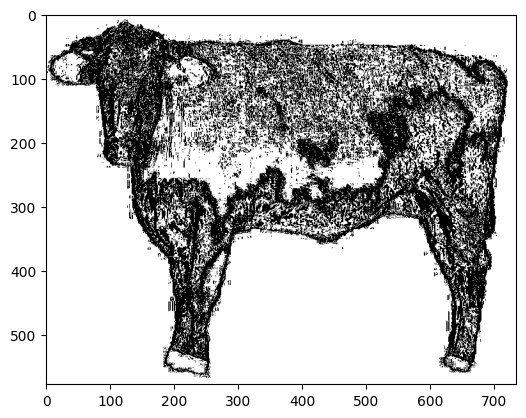

In [26]:
def calc_thresh(value, thresh):
    if value > thresh:
        return 0
    else:
        return 255


def calc_new_value(im, i, j, thresh):
    m, n = get_shape(im)
    a = m
    h = 1

    if j == 0:
        a = im[i][j]
        b = im[i][j+1]
        # forward
    elif j == n - 1:
        a = im[i][j]
        b = im[i][j-1]
        # backward
    else:
        a = im[i][j+1]
        b = im[i][j-1]
        h = 2
    return calc_thresh(abs(int(a[0]) - int(b[0])) / h, thresh)  # Update the list subtraction



def apply(im, thresh):
    new_im = [row[:] for row in im]
    for i in range(len(im)):
        for j in range(len(im[i])):
            new_im[i][j] = calc_new_value(im, i, j, thresh)
    return new_im


def display_im(im):
    plt.imshow(im, cmap='gray')
    plt.show()




result = apply(image,1)
display_im(result)
